# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][1].shape

([0,
  array([ 0.03745049, -0.17047121,  0.00157801,  0.32264692]),
  1.0,
  False,
  {}],
 (4,))

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.721590962063751 -2.8090098120324365


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    return states, actions

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states, actions, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                     labels=actions_labels))        
    return actions_logits, loss

In [10]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)
print(np.max(actions))
print(np.min(actions))

state size:(1000, 4) actions:(1000,)
2
1
0


In [13]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [14]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
env.reset()

array([ 0.00226954,  0.04834256,  0.01660639, -0.03209728])

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
state, reward, action

(array([-0.11498726, -1.38768513,  0.1293521 ,  1.9792594 ]), 1.0, 0)

In [19]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            #action *= 1 - float(done) # last action is always 0
            if done is True: action = 0 # 0, 1 but 2 means the end
            batch.append([state, action, reward, done])
            state = next_state
            total_reward += reward
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        #rewards = np.array([each[2] for each in batch])
        #dones = np.array([each[3] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                 model.actions: actions})
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Batch loss: {:.9f}'.format(loss))
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, loss])
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

Episode: 0 Total reward: 10.0 Batch loss: 0.662396073
Episode: 1 Total reward: 9.0 Batch loss: 0.645320237
Episode: 2 Total reward: 10.0 Batch loss: 0.615989506
Episode: 3 Total reward: 10.0 Batch loss: 0.590449810
Episode: 4 Total reward: 8.0 Batch loss: 0.598949432
Episode: 5 Total reward: 11.0 Batch loss: 0.543544710
Episode: 6 Total reward: 9.0 Batch loss: 0.555861771
Episode: 7 Total reward: 9.0 Batch loss: 0.551772535
Episode: 8 Total reward: 8.0 Batch loss: 0.565202296
Episode: 9 Total reward: 9.0 Batch loss: 0.538762808
Episode: 10 Total reward: 10.0 Batch loss: 0.516492605
Episode: 11 Total reward: 9.0 Batch loss: 0.526731253
Episode: 12 Total reward: 8.0 Batch loss: 0.543656468
Episode: 13 Total reward: 10.0 Batch loss: 0.500455201
Episode: 14 Total reward: 9.0 Batch loss: 0.519568980
Episode: 15 Total reward: 9.0 Batch loss: 0.516411722
Episode: 16 Total reward: 10.0 Batch loss: 0.494449139
Episode: 17 Total reward: 9.0 Batch loss: 0.508731961
Episode: 18 Total reward: 10.0 

Episode: 157 Total reward: 24.0 Batch loss: 0.235349461
Episode: 158 Total reward: 19.0 Batch loss: 0.188878253
Episode: 159 Total reward: 22.0 Batch loss: 0.192289010
Episode: 160 Total reward: 29.0 Batch loss: 0.239503235
Episode: 161 Total reward: 23.0 Batch loss: 0.296018094
Episode: 162 Total reward: 30.0 Batch loss: 0.173905715
Episode: 163 Total reward: 22.0 Batch loss: 0.159280390
Episode: 164 Total reward: 30.0 Batch loss: 0.167949885
Episode: 165 Total reward: 26.0 Batch loss: 0.149685234
Episode: 166 Total reward: 29.0 Batch loss: 0.157128677
Episode: 167 Total reward: 27.0 Batch loss: 0.172761694
Episode: 168 Total reward: 33.0 Batch loss: 0.147265434
Episode: 169 Total reward: 30.0 Batch loss: 0.180744424
Episode: 170 Total reward: 29.0 Batch loss: 0.145916715
Episode: 171 Total reward: 31.0 Batch loss: 0.136719882
Episode: 172 Total reward: 36.0 Batch loss: 0.147404969
Episode: 173 Total reward: 42.0 Batch loss: 0.143472955
Episode: 174 Total reward: 37.0 Batch loss: 0.13

Episode: 304 Total reward: 200.0 Batch loss: 0.343096912
Episode: 305 Total reward: 127.0 Batch loss: 0.051853292
Episode: 306 Total reward: 200.0 Batch loss: 0.203903630
Episode: 307 Total reward: 200.0 Batch loss: 0.307950884
Episode: 308 Total reward: 200.0 Batch loss: 0.353163868
Episode: 309 Total reward: 200.0 Batch loss: 0.334766835
Episode: 310 Total reward: 103.0 Batch loss: 0.048482612
Episode: 311 Total reward: 114.0 Batch loss: 0.041607603
Episode: 312 Total reward: 200.0 Batch loss: 0.278210342
Episode: 313 Total reward: 100.0 Batch loss: 0.052110743
Episode: 314 Total reward: 200.0 Batch loss: 0.342474252
Episode: 315 Total reward: 108.0 Batch loss: 0.059649378
Episode: 316 Total reward: 200.0 Batch loss: 0.255859405
Episode: 317 Total reward: 200.0 Batch loss: 0.343490243
Episode: 318 Total reward: 200.0 Batch loss: 0.271189749
Episode: 319 Total reward: 76.0 Batch loss: 0.143048570
Episode: 320 Total reward: 115.0 Batch loss: 0.047534313
Episode: 321 Total reward: 200.0

Episode: 448 Total reward: 200.0 Batch loss: 0.032855779
Episode: 449 Total reward: 73.0 Batch loss: 0.044586953
Episode: 450 Total reward: 200.0 Batch loss: 0.287499607
Episode: 451 Total reward: 200.0 Batch loss: 0.022335572
Episode: 452 Total reward: 200.0 Batch loss: 0.287285805
Episode: 453 Total reward: 200.0 Batch loss: 0.234629497
Episode: 454 Total reward: 189.0 Batch loss: 0.044008549
Episode: 455 Total reward: 200.0 Batch loss: 0.163164437
Episode: 456 Total reward: 200.0 Batch loss: 0.174220175
Episode: 457 Total reward: 200.0 Batch loss: 0.251467198
Episode: 458 Total reward: 200.0 Batch loss: 0.232760444
Episode: 459 Total reward: 200.0 Batch loss: 0.197426304
Episode: 460 Total reward: 200.0 Batch loss: 0.255721748
Episode: 461 Total reward: 200.0 Batch loss: 0.248248726
Episode: 462 Total reward: 200.0 Batch loss: 0.251269698
Episode: 463 Total reward: 90.0 Batch loss: 0.141696543
Episode: 464 Total reward: 155.0 Batch loss: 0.057874482
Episode: 465 Total reward: 200.0 

Episode: 592 Total reward: 200.0 Batch loss: 0.262218505
Episode: 593 Total reward: 200.0 Batch loss: 0.207939416
Episode: 594 Total reward: 93.0 Batch loss: 0.141940594
Episode: 595 Total reward: 200.0 Batch loss: 0.290305734
Episode: 596 Total reward: 200.0 Batch loss: 0.103316896
Episode: 597 Total reward: 200.0 Batch loss: 0.289078891
Episode: 598 Total reward: 200.0 Batch loss: 0.243627876
Episode: 599 Total reward: 200.0 Batch loss: 0.295886606
Episode: 600 Total reward: 200.0 Batch loss: 0.200919643
Episode: 601 Total reward: 149.0 Batch loss: 0.120889790
Episode: 602 Total reward: 200.0 Batch loss: 0.328697711
Episode: 603 Total reward: 200.0 Batch loss: 0.282806128
Episode: 604 Total reward: 200.0 Batch loss: 0.223301709
Episode: 605 Total reward: 146.0 Batch loss: 0.024891399
Episode: 606 Total reward: 200.0 Batch loss: 0.244934097
Episode: 607 Total reward: 79.0 Batch loss: 0.168103993
Episode: 608 Total reward: 200.0 Batch loss: 0.316244036
Episode: 609 Total reward: 200.0 

Episode: 738 Total reward: 200.0 Batch loss: 0.271589369
Episode: 739 Total reward: 200.0 Batch loss: 0.253053904
Episode: 740 Total reward: 68.0 Batch loss: 0.154881731
Episode: 741 Total reward: 83.0 Batch loss: 0.064364709
Episode: 742 Total reward: 200.0 Batch loss: 0.244743407
Episode: 743 Total reward: 82.0 Batch loss: 0.043807983
Episode: 744 Total reward: 200.0 Batch loss: 0.319135189
Episode: 745 Total reward: 200.0 Batch loss: 0.264851809
Episode: 746 Total reward: 152.0 Batch loss: 0.037950948
Episode: 747 Total reward: 200.0 Batch loss: 0.194015309
Episode: 748 Total reward: 200.0 Batch loss: 0.311261833
Episode: 749 Total reward: 58.0 Batch loss: 0.162003025
Episode: 750 Total reward: 200.0 Batch loss: 0.288970053
Episode: 751 Total reward: 200.0 Batch loss: 0.275609821
Episode: 752 Total reward: 200.0 Batch loss: 0.313068390
Episode: 753 Total reward: 200.0 Batch loss: 0.270008326
Episode: 754 Total reward: 200.0 Batch loss: 0.298367858
Episode: 755 Total reward: 200.0 Ba

Episode: 883 Total reward: 200.0 Batch loss: 0.261852264
Episode: 884 Total reward: 200.0 Batch loss: 0.209974483
Episode: 885 Total reward: 99.0 Batch loss: 0.034708645
Episode: 886 Total reward: 193.0 Batch loss: 0.084428027
Episode: 887 Total reward: 200.0 Batch loss: 0.280442685
Episode: 888 Total reward: 200.0 Batch loss: 0.279321104
Episode: 889 Total reward: 200.0 Batch loss: 0.283666253
Episode: 890 Total reward: 200.0 Batch loss: 0.271652043
Episode: 891 Total reward: 200.0 Batch loss: 0.284942359
Episode: 892 Total reward: 200.0 Batch loss: 0.229928508
Episode: 893 Total reward: 200.0 Batch loss: 0.289059907
Episode: 894 Total reward: 200.0 Batch loss: 0.286070764
Episode: 895 Total reward: 200.0 Batch loss: 0.270410776
Episode: 896 Total reward: 200.0 Batch loss: 0.281168669
Episode: 897 Total reward: 81.0 Batch loss: 0.033716712
Episode: 898 Total reward: 200.0 Batch loss: 0.217924535
Episode: 899 Total reward: 200.0 Batch loss: 0.253270239
Episode: 900 Total reward: 200.0 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

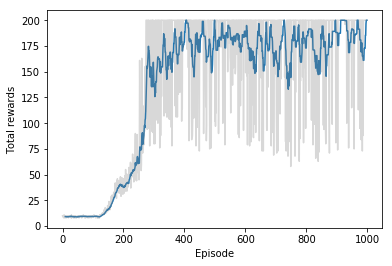

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

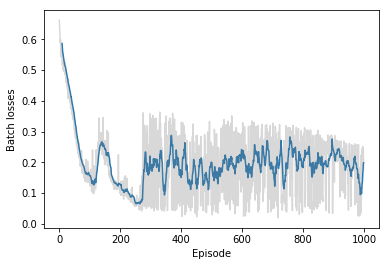

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-pg.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-pg.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.